# Classifying pictures using machine learning
The objective of this project is to build an accurate classifier of digits (numbers) from a set of images, one of the most basic problems in image recognition. The dataset used comes preloaded with the sklearn module.

Steps:
- A k-nearest neighbor algorithm is first trained, and its performance evaluated, to serve as a baseline model
- The impact of the k parameter on the knn model is evaluated
- A single hidden layer NN is trained and evaluated for different layer sizes
- A two hidden layer NN is trained for different layer sizes
- A three hidden layer NN is trained for different layer sizes
- The impact of the activation function used is evaluated for single, double, and triple layer NN of 256 neurons in each

## Reading the dataset
The data is included in the sklearn.datasets module as a dictionary with a key 'data' containing the image pixel values (as a row), and 'target' containing the value of the digit represented in the image.

In [48]:
from sklearn.datasets import load_digits
import pandas as pd
digits = load_digits()

In [49]:
data = pd.DataFrame(digits.data)
labels = pd.Series(digits.target)
print(len(data))
data.head()

1797


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


Each row in data represents the 64 pixel values of an 8x8 image. There are a total of 1797 images. To visualize these, we must reshape each row correctly.
## Visualizing the data
Let's take a look at some of the images.

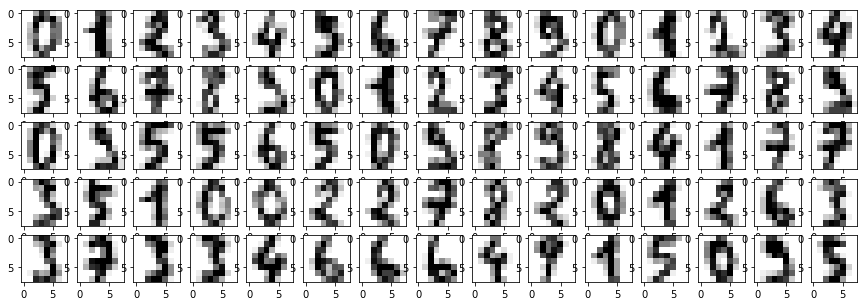

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(5, 15,figsize=(15,5))
count = 0
for row in range(5):
    for col in range(15):
        axes[row,col].imshow(data.iloc[count].values.reshape(8,8), cmap='gray_r')
        count+=1

## Baseline Performance of a k-nearest neighbors algorithm
As a baseline, let's find out how accurate a k-nearest neighbors algorithm can be. We will use sklearns built-in training and validation methods to make the process of developing the model extremely easy.

The hyperparemeters for this model are set to k=5 nearest neighbors and n=4 cross-validation folds.

In [78]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# returns a knn model trained on the given inputs
def train(train_features, train_labels, k=5):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_features, train_labels)
    return knn

# returns the accuracy of the given model on the given inputs
def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = sum(predictions == test_labels)/len(predictions)
    return accuracy

# returns the average accuracy accross multiple cross validations
def cross_validate(n=4, k=5):
    accuracies = []
    kf = KFold(n_splits = n, random_state=2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train(train_features, train_labels, k=k)
        overall_accuracy = test(model, test_features, test_labels)
        accuracies.append(overall_accuracy)
    return sum(accuracies)/len(accuracies)

cross_validate()

0.9621665429349171

The average accuracy accross the 4 cross-validations is 96%. Pretty good! Let's see if this can be improved by varying the k value, the number of nearest neighbors.

[0.9677233358079684, 0.9616010888393962, 0.9627183865379857, 0.9649480326651819, 0.9621665429349171, 0.9588270230141054, 0.9571591190299431, 0.9571578817124474, 0.9543801039346697, 0.9527097253155159]


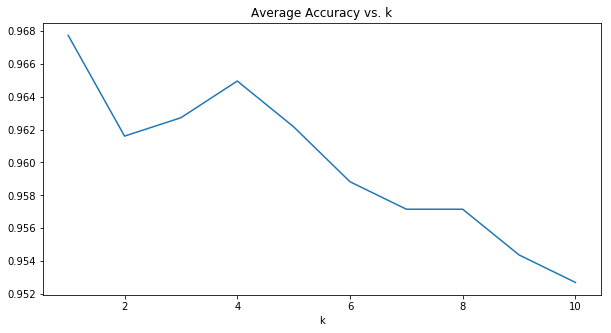

In [79]:
k_list = list(range(1,11))
accuracies = []
for k in k_list:
    accuracies.append(cross_validate(k=k))

plt.figure(figsize=(10,5))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.title("Average Accuracy vs. k")
print(accuracies)

### Observations
The best result is obtained from k=1, but the loss of accuracy with higher k values is small. Let's keep this target of nearly 97% accuracy when experimenting with neural networks.

## Performance of a single hidden layer neural network
Let's start the evaluation of neural networks (aka multi layer perceptrons, mlp) for this image classification task with the simplest type: single hidden layer. Let's explore how the number of nodes in this single layer affects the accuracy on the test and training sets, this should indicate if/where overfitting happens: high accuracy on the training set and lower accuracy on the testing set is a sign of overfitting.

In [68]:
from sklearn.neural_network import MLPClassifier
layer_sizes_single_layer = [(8, ), (16, ), (32, ), (64, ), (128, ), (256, )]

# returns a mlp model trained on the given inputs
def train_nn(train_features, train_labels, size):
    mlp = MLPClassifier(hidden_layer_sizes = size, activation='logistic', max_iter=500)
    mlp.fit(train_features, train_labels)
    return mlp

train_accuracies_single_layer = []
test_accuracies_single_layer = []

# loop through each layer size
# compute the average accuracy accross multiple cross validations for both training and testing sets
for size in layer_sizes_single_layer:
    kf = KFold(n_splits = 4, random_state=1)
    train_accuracies_folds = []
    test_accuracies_folds = []
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_nn(train_features, train_labels, size)
        train_accuracies_folds.append(test(model, train_features, train_labels))
        test_accuracies_folds.append(test(model, test_features, test_labels))
    train_accuracies_single_layer.append(sum(train_accuracies_folds)/len(train_accuracies_folds))
    test_accuracies_single_layer.append(sum(test_accuracies_folds)/len(test_accuracies_folds))

print(train_accuracies_single_layer)
print(test_accuracies_single_layer)

C:\Users\Lourenco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lourenco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lourenco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lourenco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_it

[0.9871999596862133, 0.9988871026723855, 1.0, 1.0, 1.0, 1.0]
[0.8859168522642911, 0.9259910913140312, 0.9471343726800296, 0.9493590695372432, 0.9515862410294481, 0.9543652561247216]


Text(0.5, 0, 'Hidden layer size')

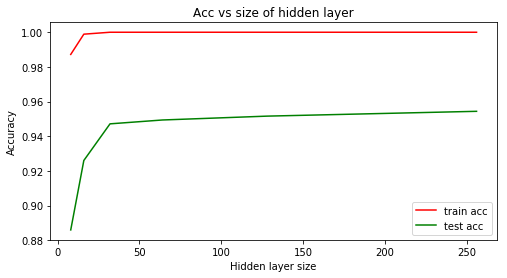

In [69]:
plt.figure(figsize=(8,4))
plt.plot([x[0] for x in layer_sizes_single_layer], train_accuracies_single_layer, 'r', label='train acc')
plt.plot([x[0] for x in layer_sizes_single_layer], test_accuracies_single_layer, 'g', label='test acc')
plt.legend()
plt.title('Acc vs size of hidden layer')
plt.ylabel('Accuracy')
plt.xlabel('Hidden layer size')

### Observations
The number of neurons has a great impact on he accuracy of the model. The accuracy on the testing set is greatest for the 256 neuron sized layer, approaching the performance of the KNN algorithm with 95% accuracy. Each model overfits, with the training set having much better results. Let's see if this performance can be improved using two hidden layers.
## Performance of a two hidden layer neural network

In [70]:
layer_sizes_two_layer = [
    (16,16),
    (64,64),
    (128, 128),
    (256, 256)]

train_accuracies_two_layer = []
test_accuracies_two_layer = []
for size in layer_sizes_two_layer:
    kf = KFold(n_splits = 4, random_state=1)
    train_accuracies_folds = []
    test_accuracies_folds = []
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_nn(train_features, train_labels, size)
        train_accuracies_folds.append(test(model, train_features, train_labels))
        test_accuracies_folds.append(test(model, test_features, test_labels))
    train_accuracies_two_layer.append(sum(train_accuracies_folds)/len(train_accuracies_folds))
    test_accuracies_two_layer.append(sum(test_accuracies_folds)/len(test_accuracies_folds))
    
print(train_accuracies_two_layer)
print(test_accuracies_two_layer)

C:\Users\Lourenco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lourenco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lourenco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lourenco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_it

[0.9998144023756496, 1.0, 1.0, 1.0]
[0.9109576837416482, 0.938787428854244, 0.9532541450136104, 0.9521393219500124]


Text(0.5, 0, 'Hidden layer size')

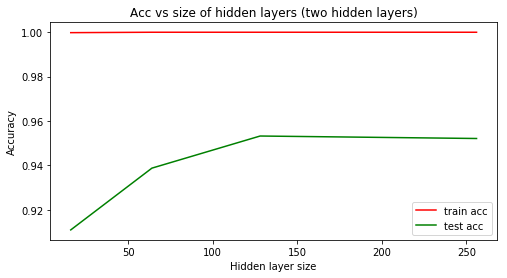

In [80]:
plt.figure(figsize=(8,4))
plt.plot([x[0] for x in layer_sizes_two_layer], train_accuracies_two_layer, 'r', label='train acc')
plt.plot([x[0] for x in layer_sizes_two_layer], test_accuracies_two_layer, 'g', label='test acc')
plt.legend()
plt.title('Acc vs size of hidden layers (two hidden layers)')
plt.ylabel('Accuracy')
plt.xlabel('Hidden layer size')

Text(0.5, 0, 'Hidden layer size')

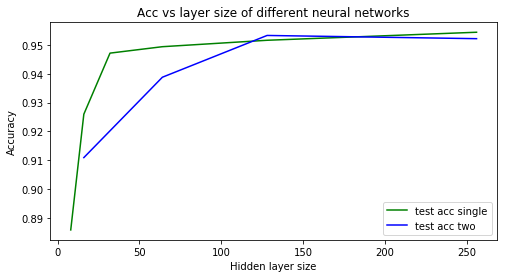

In [72]:
plt.figure(figsize=(8,4))
plt.plot([x[0] for x in layer_sizes_single_layer], test_accuracies_single_layer, 'g', label='test acc single')
plt.plot([x[0] for x in layer_sizes_two_layer], test_accuracies_two_layer, 'b', label='test acc two')
plt.legend()
plt.title('Acc vs layer size of different neural networks')
plt.ylabel('Accuracy')
plt.xlabel('Hidden layer size')

### Observations
There is little to no improvement at two hidden layers over a single layer. After 128, increasing the number of neurons actually decreases performance.
## Performance of a three hidden layer neural network

In [73]:
layer_sizes_three_layer = [
    (16, 16, 16),
    (64, 64, 64),
    (128, 128, 128),
    (256, 256, 256)]

train_accuracies_three_layer = []
test_accuracies_three_layer = []
for size in layer_sizes_three_layer:
    kf = KFold(n_splits = 4, random_state=1)
    train_accuracies_folds = []
    test_accuracies_folds = []
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_nn(train_features, train_labels, size)
        train_accuracies_folds.append(test(model, train_features, train_labels))
        test_accuracies_folds.append(test(model, test_features, test_labels))
    train_accuracies_three_layer.append(sum(train_accuracies_folds)/len(train_accuracies_folds))
    test_accuracies_three_layer.append(sum(test_accuracies_folds)/len(test_accuracies_folds))
    
print(train_accuracies_three_layer)
print(test_accuracies_three_layer)

C:\Users\Lourenco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lourenco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lourenco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lourenco\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_it

[0.9968469056415069, 1.0, 1.0, 1.0]
[0.8608661222469687, 0.9276515713932196, 0.9337738183617916, 0.9471306607275427]


Text(0.5, 0, 'Hidden layer size')

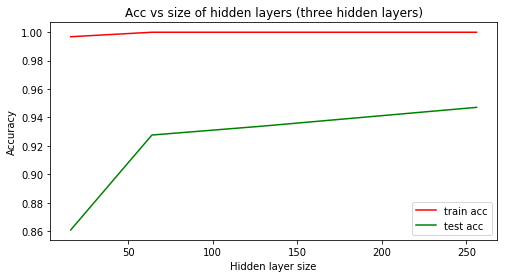

In [74]:
plt.figure(figsize=(8,4))
plt.plot([x[0] for x in layer_sizes_three_layer], train_accuracies_three_layer, 'r', label='train acc')
plt.plot([x[0] for x in layer_sizes_three_layer], test_accuracies_three_layer, 'g', label='test acc')
plt.legend()
plt.title('Acc vs size of hidden layers (three hidden layers)')
plt.ylabel('Accuracy')
plt.xlabel('Hidden layer size')

Text(0.5, 0, 'Hidden layer size')

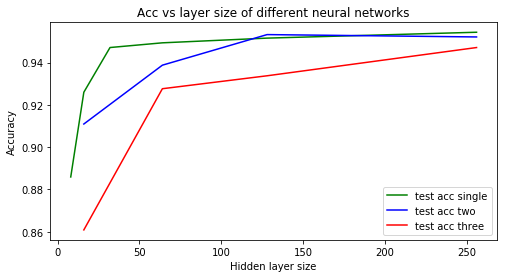

In [75]:
plt.figure(figsize=(8,4))
plt.plot([x[0] for x in layer_sizes_single_layer], test_accuracies_single_layer, 'g', label='test acc single')
plt.plot([x[0] for x in layer_sizes_two_layer], test_accuracies_two_layer, 'b', label='test acc two')
plt.plot([x[0] for x in layer_sizes_three_layer], test_accuracies_three_layer, 'r', label='test acc three')
plt.legend()
plt.title('Acc vs layer size of different neural networks')
plt.ylabel('Accuracy')
plt.xlabel('Hidden layer size')

### Observations
The three layer neural network performs worse than its peers at every size. 
## Varying the activation function
Let's see if trying different activation functions can improve the performance of our models. So far, we have been using the logistic function. Let's try single, double, and three layers at 256 neurons each using the tanh and relu functions.

In [76]:
activation_functions = ['tanh', 'relu']

layer_sizes_func =[
    (256, ),
    (256, 256),
    (256, 256, 256)]

accuracies_all = []
for func in activation_functions:
    accuracies_func = []
    for size in layer_sizes_func:
        kf = KFold(n_splits = 4, random_state=1)
        train_accuracies_folds = []
        test_accuracies_folds = []
        for train_index, test_index in kf.split(data):
            train_features, test_features = data.loc[train_index], data.loc[test_index]
            train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
            model = train_nn(train_features, train_labels, size)
            test_accuracies_folds.append(test(model, test_features, test_labels))
        accuracies_func.append(sum(test_accuracies_folds)/len(test_accuracies_folds))
    accuracies_all.append(accuracies_func)
    
print(accuracies_all)

[[0.9515837663944569, 0.9538072259341747, 0.9487973273942093], [0.9532529076961148, 0.9510257362039098, 0.9499146250927988]]


Text(0.5, 0, 'Number of hidden layers')

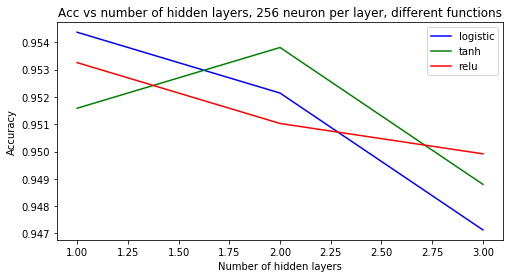

In [77]:
layers = [1, 2, 3]
plt.figure(figsize=(8,4))
plt.plot(layers, [test_accuracies_single_layer[-1],test_accuracies_two_layer[-1], test_accuracies_three_layer[-1]],'b', label='logistic')
plt.plot(layers, accuracies_all[0],'g', label='tanh')
plt.plot(layers, accuracies_all[1],'r', label='relu')
plt.legend()
plt.title('Acc vs number of hidden layers, 256 neuron per layer, different functions')
plt.ylabel('Accuracy')
plt.xlabel('Number of hidden layers')

The impact of the activation function is minor, as all accuracy values are within less than 1% of each other.
## Conclusion
Although Neural Networks did not improve on the performance of the k-nearest neighbors model, they did not fall behind by much. Furthermore, once trained, these models require little computation to estimate new values, unlike k-nearest neighbors, for which the distances must be reevaluated for each new estimation.

To improve the performance of neural networks, the next project uses Convolutional Networks to perform the same task.